In [4]:
import numpy as np
import pandas as pd
import os
import pathlib as Path
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import requests
from police_api import PoliceAPI

api = PoliceAPI()

px.set_mapbox_access_token("pk.eyJ1IjoibXJhZmlwaCIsImEiOiJjbGMzdWZ0MTIwNmt5M3B0ODNnbzF1a3d2In0.7VgLitY9OXxhPSxlxJglfQ")

In [5]:
df_out_2023_03 = pd.read_csv(r'.\\Datasets\\2022-2023\\2023-03\\2023-03-metropolitan-outcomes.csv')
df_ss_2023_03 = pd.read_csv(r'.\\Datasets\\2022-2023\\2023-03\\2023-03-metropolitan-stop-and-search.csv')
df_street_2011_02 = pd.read_csv(r'.\\Datasets\\2010-2017\\2011-02\\2011-02-metropolitan-street.csv')
df_street_2011_02[df_street_2011_02['Crime type'] == 'Burglary'].head()


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
25,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.128330,51.584559,On or near Nash Road,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
26,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.126964,51.586508,On or near Rowan Way,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
27,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.129225,51.583922,On or near Gregory Road,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
28,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.131680,51.586432,On or near Newhouse Avenue,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
38,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.139479,51.579743,On or near Yew Tree Gardens,E01000029,Barking and Dagenham 001C,Burglary,NaN,NaN


In [6]:
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

subfolders = fast_scandir(r'./Datasets')

In [7]:
all_street_df = []
all_ss_df = []
all_outcome_df = []
for i in range(4, len(subfolders)):
    street_file_name =  [ file for file in os.listdir(subfolders[i]) if "street" in file]
    ss_file_name = [ file for file in os.listdir(subfolders[i]) if "search" in file]
    outcome_file_name = [ file for file in os.listdir(subfolders[i]) if "outcome" in file]
    if len(street_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], street_file_name[0]))
        all_street_df.append(df)
    elif len(ss_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], ss_file_name[0]))
        all_ss_df.append(df)
    if len(outcome_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], outcome_file_name[0]))
        all_outcome_df.append(df)

In [8]:
street_all_years = pd.concat(all_street_df, ignore_index=True)
df_clean = street_all_years.drop(columns=['Context'])
df_clean['Month']= pd.to_datetime(df_clean['Month'])
df_clean['Year'] = df_clean['Month'].dt.year
df_clean = df_clean.rename(columns={'Month': 'Date'})
df_clean['Month'] = df_clean['Date'].dt.month
burglary_data = df_clean.loc[(df_clean['Crime type'] == 'Burglary') & (df_clean['LSOA name'].str.contains("Barnet"))]
burglary_data.head()


,Crime ID,Date,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Year,Month
2179,NaN,2011-02-01,Metropolitan Police Service,Metropolitan Police Service,-0.201877,51.655538,On or near High Street,E01000248,Barnet 001A,Burglary,NaN,2011,2
2180,NaN,2011-02-01,Metropolitan Police Service,Metropolitan Police Service,-0.209353,51.654393,On or near Ravenscroft Park,E01000248,Barnet 001A,Burglary,NaN,2011,2
2181,NaN,2011-02-01,Metropolitan Police Service,Metropolitan Police Service,-0.201877,51.655538,On or near High Street,E01000248,Barnet 001A,Burglary,NaN,2011,2
2182,NaN,2011-02-01,Metropolitan Police Service,Metropolitan Police Service,-0.204722,51.655249,On or near Stapylton Road,E01000248,Barnet 001A,Burglary,NaN,2011,2
2213,NaN,2011-02-01,Metropolitan Police Service,Metropolitan Police Service,-0.201462,51.656161,On or near Bath Place,E01000250,Barnet 001C,Burglary,NaN,2011,2


In [9]:
fig = ff.create_hexbin_mapbox(
            data_frame=burglary_data, lat="Latitude", lon="Longitude",
            opacity=1.0, labels={"color": "Point Count"},
            min_count=1, zoom=10, show_original_data=True
        )
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

In [10]:
burglary_data = burglary_data.loc[(burglary_data['Year'] != 2020) | (burglary_data['Year'] != 2021)]
df_training = burglary_data.loc[(burglary_data['Year'] != 2022) | (burglary_data['Year'] != 2023)]
df_val = burglary_data.loc[(burglary_data['Year'] == 2022) | (burglary_data['Year'] == 2023)]
training_grouped = df_training.groupby(['Date']).count()
validation_grouped = df_val.groupby(['Date']).count()

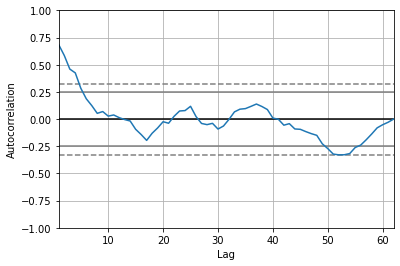

In [11]:
import matplotlib.pyplot as plt

s = training_grouped['Location']

# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(s)
 
# plotting the Curve
x.plot()
 
# Display
plt.show()

<AxesSubplot: xlabel='Date'>

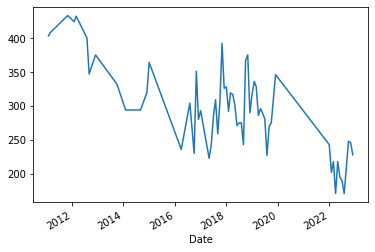

In [12]:
# Growth of burglaries over the years
s.plot()

p-value: 0.1109480543770518


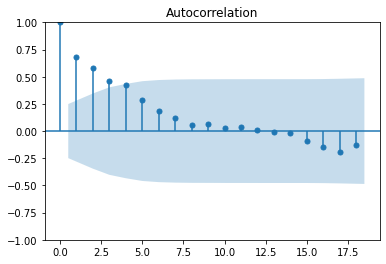

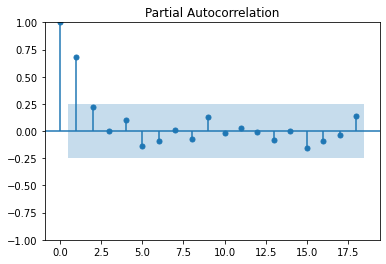

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# ADF test to see stationarity
adf_test = adfuller(training_grouped[['Location']])
# When p <= 0.05, then data is stationary
print(f'p-value: {adf_test[1]}')
# Compute autocorrelation
acf = plot_acf(training_grouped[['Location']])

# Compute partial autocorrelation function
pacf = plot_pacf(training_grouped[['Location']])


<AxesSubplot: xlabel='Date'>

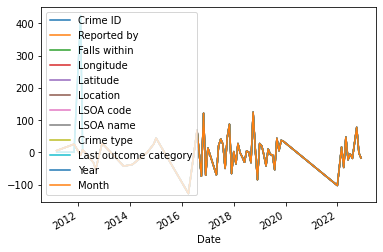

In [14]:
df_train_diff = training_grouped.diff().dropna()
df_train_diff.plot()

p-value: 1.6513156315275028e-09


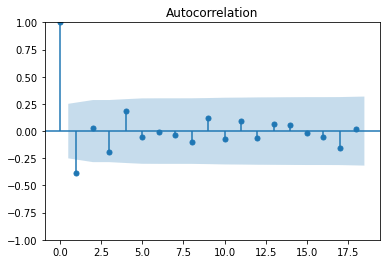

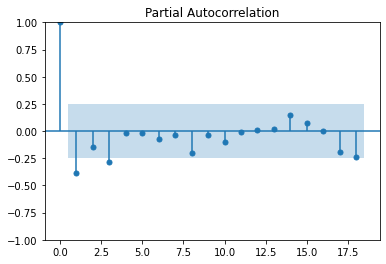

In [15]:
# ADF test to see stationarity
adf_test_new = adfuller(df_train_diff[['Location']])
# When p <= 0.05, then data is stationary
print(f'p-value: {adf_test_new[1]}')
# Compute autocorrelation
acf = plot_acf(df_train_diff[['Location']])

# Compute partial autocorrelation function
pacf = plot_pacf(df_train_diff[['Location']])

In [16]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(df_train_diff['Location'], order=(0,0,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Location   No. Observations:                   61
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -316.300
Date:                Fri, 26 May 2023   AIC                            638.600
Time:                        23:26:20   BIC                            644.932
Sample:                             0   HQIC                           641.081
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1092      2.517     -1.235      0.217      -8.042       1.823
ma.L1         -0.5646      0.110     -5.155      0.000      -0.779      -0.350
sigma2      1856.2397    334.451      5.550      0.0

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



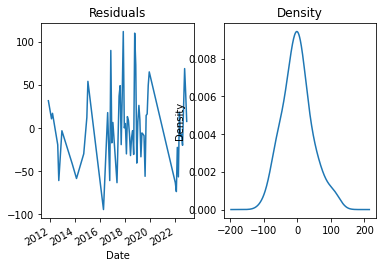

In [17]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

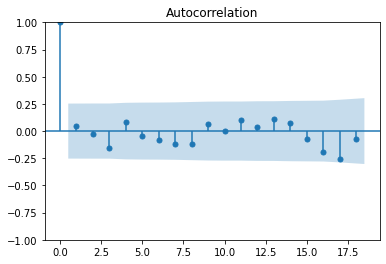

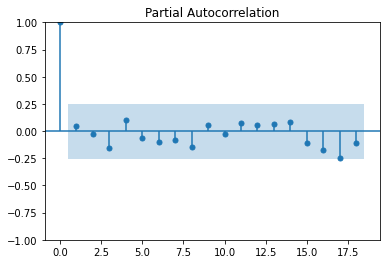

In [18]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



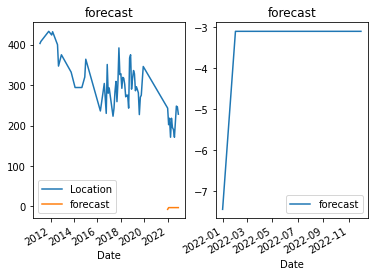

<Figure size 720x720 with 0 Axes>

In [19]:
forecast_test = model_fit.forecast(len(validation_grouped))
validation_grouped['forecast'] = list(forecast_test)

fig1, ax1 = plt.subplots(1,2)
training_grouped[['Location']].plot(title='Original', ax=ax1[0])
validation_grouped[['forecast']].plot(title='forecast', ax=ax1[0])
validation_grouped[['forecast']].plot(title='forecast', ax=ax1[1])
plt.figure(figsize=(10,10))
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

train, test = training_grouped['Crime ID'], validation_grouped['Crime ID']
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(0,0,1))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

predicted=260.405378, expected=243.000000
predicted=266.567057, expected=202.000000
predicted=243.333850, expected=218.000000
predicted=260.843872, expected=171.000000
predicted=228.880547, expected=218.000000
predicted=265.302509, expected=195.000000
predicted=236.329158, expected=190.000000
predicted=246.343579, expected=171.000000
predicted=230.899786, expected=248.000000
predicted=274.519908, expected=246.000000
predicted=252.771518, expected=228.000000
Test RMSE: 50.262
Test MAE: 42.763
Test MSE: 2526.262


In [21]:
burglary_data_grouped = burglary_data.groupby(['Year', 'Month']).count()
burglary_data_grouped.reset_index(inplace=True)
fig_mult = px.line(burglary_data_grouped, x='Month', y='Location', color='Year',
                   title="Seasonal Plot: Burglary Cases Growth")
fig_mult.update_yaxes(title="Number of Cases")
fig_mult.update_traces(mode="markers+lines", hovertemplate=None)
fig_mult.update_layout(hovermode="x unified")

fig_mult.show()

In [22]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train_diff[['Location']], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [23]:
auto_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -316.992
Date:                Fri, 26 May 2023   AIC                            637.985
Time:                        23:26:35   BIC                            642.207
Sample:                             0   HQIC                           639.639
                                 - 61                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5125      0.113     -4.530      0.000      -0.734      -0.291
sigma2      1901.1469    351.270      5.412      0.000    1212.670    2589.624
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.95   Prob(JB):                         0.48
Heteroskedasticity (H):               0.76   Skew:                             0.37
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



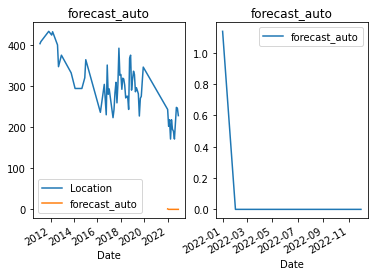

<Figure size 720x720 with 0 Axes>

In [24]:
forecast_test_auto = auto_arima.predict(len(validation_grouped))
validation_grouped['forecast_auto'] = list(forecast_test_auto)

fig2, ax2 = plt.subplots(1,2)
training_grouped[['Location']].plot(title='Original', ax=ax2[0])
validation_grouped[['forecast_auto']].plot(title='forecast_auto', ax=ax2[0])
validation_grouped[['forecast_auto']].plot(title='forecast_auto', ax=ax2[1])
plt.figure(figsize=(10,10))
plt.show()

In [25]:
xls = pd.ExcelFile(r'.\\Datasets\\Police Workforce\\open-data-table-police-workforce-270722.ods')

# Now you can list all sheets in the file
xls.sheet_names

pwf = pd.read_excel(r'.\\Datasets\\Police Workforce\\open-data-table-police-workforce-270722.ods', sheet_name='Data')
pwf.head()


,As at 31 March...,Geo code,Force Name,Region,Sex,Rank description,Worker type,Total (headcount),Total (FTE)
0,2007,E23000036,Avon & Somerset,South West,Female,Chief Inspector,Police Officer,7,6.60
1,2007,E23000036,Avon & Somerset,South West,Female,Chief Officer,Police Officer,1,1.00
2,2007,E23000036,Avon & Somerset,South West,Female,Chief Superintendent,Police Officer,4,4.00
3,2007,E23000036,Avon & Somerset,South West,Female,Community Support Officer,Police Community Support Officer,170,164.99
4,2007,E23000036,Avon & Somerset,South West,Female,Constable,Police Officer,722,672.76


In [26]:
pwf_data_all_years = pwf.loc[(pwf['Force Name']=='Metropolitan Police') & (pwf['Total (headcount)'] != 0) & (pwf['As at 31 March...'] > 2010)]
pwf_data_all_years = pwf_data_all_years.rename(columns={'As at 31 March...':'Year'})
pwf_data_all_years = pwf_data_all_years.fillna(0)
pwf_data_all_years['Total (FTE)'] = pwf_data_all_years['Total (FTE)'].astype(int)
pwf_data_all_years.head(100)

,Year,Geo code,Force Name,Region,Sex,Rank description,Worker type,Total (headcount),Total (FTE)
6030,2011,E23000001,Metropolitan Police,London,Female,Chief Inspector,Police Officer,58,57
6031,2011,E23000001,Metropolitan Police,London,Female,Chief Officer,Police Officer,8,8
6032,2011,E23000001,Metropolitan Police,London,Female,Chief Superintendent,Police Officer,8,8
6033,2011,E23000001,Metropolitan Police,London,Female,Community Support Officer,Police Community Support Officer,1452,1401
6034,2011,E23000001,Metropolitan Police,London,Female,Constable,Police Officer,6879,6514
...,...,...,...,...,...,...,...,...,...
11321,2015,E23000001,Metropolitan Police,London,Female,Police Staff,Police Staff,6682,6140
11322,2015,E23000001,Metropolitan Police,London,Female,Sergeant,Police Officer,828,773
11323,2015,E23000001,Metropolitan Police,London,Female,Special Constable,Special Constable,1163,0
11324,2015,E23000001,Metropolitan Police,London,Female,Superintendent,Police Officer,30,30


In [27]:
total = []
for y in pwf_data_all_years['Year'].unique():
    df_temp = pwf_data_all_years[pwf_data_all_years['Year']==y]
    total.append([y, df_temp['Total (FTE)'].sum()])

# Create the pandas DataFrame
dfwf = pd.DataFrame(total, columns=['Year', 'Police Workforce'])
  
# print dataframe.
dfwf

,Year,Police Workforce
0,2011,50572
1,2012,48179
2,2013,46121
3,2014,45010
4,2015,45564
5,2016,43909
6,2017,41868
7,2018,40321
8,2019,40791
9,2020,42982


In [28]:
# burglary_data_grouped = burglary_data.groupby(['Year', 'Month']).count()
burglary_data_grouped['Police Workforce'] = dfwf['Police Workforce']
burglary_data_grouped.head()
# print(len(burglary_data_grouped) == len(dfwf))

,Year,Month,Crime ID,Date,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Police Workforce
0,2011,2,0,403,403,403,403,403,403,403,403,403,0,50572.0
1,2011,3,0,408,408,408,408,408,408,408,408,408,0,48179.0
2,2011,11,0,433,433,433,433,433,433,433,433,433,0,46121.0
3,2012,2,424,424,424,424,424,424,424,424,424,424,424,45010.0
4,2012,3,432,432,432,432,432,432,432,432,432,432,432,45564.0


In [29]:
import xlwings as xw

workbook = xw.Book(r'.\\Datasets\\Population\\land-area-population-density-london.xlsx')
ward_sheet = workbook.sheets['Ward']
years = [x for x in range(2011, 2023)]
results = []
for year in years:
    ward_sheet.range('E1').value = year
    ward_sheet.api.Range("A2:K628").AutoFilter(Field:=3, Criteria1:="Barnet")
    results.append(
        {
            'Codes': ward_sheet.range('A21:A41').value,
            'Ward': ward_sheet.range('B21:B41').value,
            'Borough': ward_sheet.range('C21:C41').value,
            'Population': ward_sheet.range('D21:D41').value,
            'Year': [year]*21,
            'Hectares': ward_sheet.range('E21:E41').value,
            'Square Kilometres': ward_sheet.range('F21:F41').value,
            'Population per hectare': ward_sheet.range('G21:G41').value,	
            'Population per square kilometre': ward_sheet.range('H21:H41').value,
            'Census population (2011)': ward_sheet.range('J21:J41').value,	
            'Population per hectare': ward_sheet.range('K21:K41').value,
        }
    )

concat_pd = []
for i in range(len(results)):
    temp_df = pd.DataFrame(results[i])
    concat_pd.append(temp_df)
population_ward_df = pd.concat(concat_pd, ignore_index=True)
population_ward_df.head(-1)

,Codes,Ward,Borough,Population,Year,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011)
0,E05000043,Brunswick Park,Barnet,16454.0,2011,317.4,3.174,51.650914,5183.994959,16394.0
1,E05000044,Burnt Oak,Barnet,18279.0,2011,206.4,2.064,88.260659,8856.104651,18217.0
2,E05000045,Childs Hill,Barnet,20112.0,2011,308.9,3.089,64.904500,6510.844934,20049.0
3,E05000046,Colindale,Barnet,17153.0,2011,264.2,2.642,64.716124,6492.429977,17098.0
4,E05000047,Coppetts,Barnet,17311.0,2011,272.0,2.720,63.419118,6364.338235,17250.0
...,...,...,...,...,...,...,...,...,...,...
246,E05000058,Oakleigh,Barnet,17029.0,2022,331.7,3.317,47.666566,5133.855894,15811.0
247,E05000059,Totteridge,Barnet,17730.0,2022,876.8,8.768,17.289005,2022.125912,15159.0
248,E05000060,Underhill,Barnet,16592.0,2022,455.2,4.552,34.962654,3644.991213,15915.0
249,E05000061,West Finchley,Barnet,17794.0,2022,216.1,2.161,76.506247,8234.150856,16533.0


In [30]:
population_ward_df.loc[population_ward_df['Ward']=="Edgware"]

,Codes,Ward,Borough,Population,Year,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011)
7,E05000050,Edgware,Barnet,16787.0,2011,556.0,5.56,30.086331,3019.244604,16728.0
28,E05000050,Edgware,Barnet,17299.0,2012,556.0,5.56,30.086331,3111.330935,16728.0
49,E05000050,Edgware,Barnet,17627.0,2013,556.0,5.56,30.086331,3170.323741,16728.0
70,E05000050,Edgware,Barnet,18175.0,2014,556.0,5.56,30.086331,3268.884892,16728.0
91,E05000050,Edgware,Barnet,18633.0,2015,556.0,5.56,30.086331,3351.258993,16728.0
112,E05000050,Edgware,Barnet,19706.0,2016,556.0,5.56,30.086331,3544.244604,16728.0
133,E05000050,Edgware,Barnet,20021.0,2017,556.0,5.56,30.086331,3600.899281,16728.0
154,E05000050,Edgware,Barnet,20359.0,2018,556.0,5.56,30.086331,3661.690647,16728.0
175,E05000050,Edgware,Barnet,20656.0,2019,556.0,5.56,30.086331,3715.107914,16728.0
196,E05000050,Edgware,Barnet,21003.0,2020,556.0,5.56,30.086331,3777.517986,16728.0


In [34]:
crime_ward_df = pd.read_csv(r'.\\Datasets\\Crime History\\Ward Level Crime.csv')
crime_ward_df_grouped = crime_ward_df.groupby(['Ward', 'Year', 'Month' ], as_index=False)['Crime type'].count()
crime_ward_df_grouped.head()	

,Ward,Year,Month,Crime type
0,Barnet Vale,2011,2,29
1,Barnet Vale,2011,3,27
2,Barnet Vale,2011,11,28
3,Barnet Vale,2012,2,24
4,Barnet Vale,2012,3,32


In [35]:
fig_ward = px.line(crime_ward_df.groupby(['Ward', 'Year']).size().reset_index(name='Burglary Rate'), x='Year', y='Burglary Rate', color='Ward',
                   title="Seasonal Plot: Ward Burglary Cases Growth")
fig_ward.update_yaxes(title="Number of Cases")
fig_ward.update_traces(mode="markers+lines", hovertemplate=None)
fig_ward.update_layout(hovermode="x unified")

fig_ward.show()

In [36]:
df2 = pd.merge(crime_ward_df_grouped, population_ward_df, how='inner', on=['Year', 'Ward'])
df2 = df2.rename(columns={"Crime type":"Burglary Cases"})

df3 = pd.merge(df2, dfwf, how='inner', on='Year')
df3.head()

,Ward,Year,Month,Burglary Cases,Codes,Borough,Population,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011),Police Workforce
0,Brunswick Park,2011,2,36,E05000043,Barnet,16454.0,317.4,3.174,51.650914,5183.994959,16394.0,50572
1,Brunswick Park,2011,3,25,E05000043,Barnet,16454.0,317.4,3.174,51.650914,5183.994959,16394.0,50572
2,Brunswick Park,2011,11,43,E05000043,Barnet,16454.0,317.4,3.174,51.650914,5183.994959,16394.0,50572
3,Burnt Oak,2011,2,15,E05000044,Barnet,18279.0,206.4,2.064,88.260659,8856.104651,18217.0,50572
4,Burnt Oak,2011,3,13,E05000044,Barnet,18279.0,206.4,2.064,88.260659,8856.104651,18217.0,50572


In [41]:
income_ward_df = pd.read_csv(r'.\\Datasets\\Population\\modelled-household-income-estimates-wards.csv', encoding='latin1')
income_ward_df = income_ward_df.loc[(income_ward_df['Borough']=='Barnet')]
tomelt = [income_ward_df.columns[i] for i in range(0, 4)]
print(tomelt)
income_ward_df = pd.melt(income_ward_df, id_vars=tomelt, 
        var_name="Date", 
        value_name="Burglary Case")
income_ward_df.head()
# income_ward_df['Year'] = income_ward_df.Date.str[0:4]
# income_ward_df['Month'] = income_ward_df.Date.str[5:6]
# income_ward_df = income_ward_df.drop(['Date'], axis=1)
# income_ward_df.head(-1)

['Code', 'Ward name', 'LAD code', 'Borough', 'Mean 2001/02']


,Code,Ward name,LAD code,Borough,Mean 2001/02,Date,Burglary Case
0,E05000043,Brunswick Park,E09000003,Barnet,"£37,840",Mean 2002/03,"£38,170"
1,E05000044,Burnt Oak,E09000003,Barnet,"£26,640",Mean 2002/03,"£26,920"
2,E05000045,Childs Hill,E09000003,Barnet,"£38,500",Mean 2002/03,"£38,650"
3,E05000046,Colindale,E09000003,Barnet,"£27,820",Mean 2002/03,"£28,060"
4,E05000047,Coppetts,E09000003,Barnet,"£36,930",Mean 2002/03,"£37,160"
